In [1]:
%pprint

Pretty printing has been turned OFF


## 2016 Election Project 
### Part 2 of Processing Pipeline

This notebook is intended to document NER annotation of my data throughout this project. The data I am starting out with are transcripts of the presidential debates from the 2016 US Election- the 10 Democratic primary debates, the 12 Republican primary debates, and the debates for the general election between Hillary Clinton and Donald Trump. The transcripts were taken from UCSB's American Presidency Project. The citations for these transcripts can be found in the README.

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import re

**I'm going to create a mapping function that will take the sentence in each row of each data frame and perform nltk's chunking operation on it to get a tree with annoted NEs**

In [3]:
#Import the saved list of data frames I created in secondary_data_processing
import pickle
f = open('/Users/Paige/Documents/Data_Science/dataframes.p', 'rb')
dataframes = pickle.load(f)
f.close()

In [4]:
def get_tree(sent):
    sents = nltk.sent_tokenize(sent)
    words = [nltk.word_tokenize(sent) for sent in sents]
    pos = [nltk.pos_tag(sent) for sent in words]
    chunk = nltk.ne_chunk_sents(pos)
    return list(chunk)

In [5]:
master_df = pd.concat(dataframes)

In [6]:
master_df.head()

,Date,Debate Type,Speaker,Sents
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h..."


In [7]:
master_df.tail()

,Date,Debate Type,Speaker,Sents
1382,9-26-16,general,HOLT,The conversation will continue.
1383,9-26-16,general,HOLT,A reminder.
1384,9-26-16,general,HOLT,The vice presidential debate is scheduled for ...
1385,9-26-16,general,HOLT,My thanks to Hillary Clinton and to Donald Tru...
1386,9-26-16,general,HOLT,"Good night, everyone."


In [8]:
master_df['Tree']=master_df.Sents.map(get_tree)

In [9]:
master_df.head()

,Date,Debate Type,Speaker,Sents,Tree
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...,"[[(It, PRP), (is, VBZ), (9:00, CD), (p.m., NN)..."
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...,"[[(Welcome, VB), (to, TO), (the, DT), (sixth, ..."
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo...","[[(I, PRP), ('m, VBP), [('Neil', 'JJ'), ('Cavu..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...,"[[(Tonight, NN), (we, PRP), (are, VBP), (worki..."
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h...","[[(And, CC), (according, VBG), (to, TO), [('Fa..."


**I've created an NER tree! Notice that nltk's chunker pulled out Neil Cavuto and Maria Bartiromo as people. Now I want to change the S label at the top of the tree to represent who said this utterence using the information in the Speaker column.**

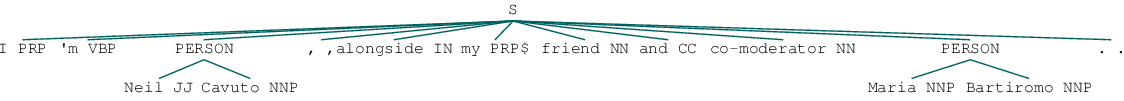

In [10]:
master_df.iloc[2][-1][0]

In [11]:
#Using mapping involving 2 columns. Use the Speaker column to modify the Tree column.
for row in range(0, len(master_df)):
    master_df.iloc[row][-1][0].set_label(master_df.iloc[row][2])

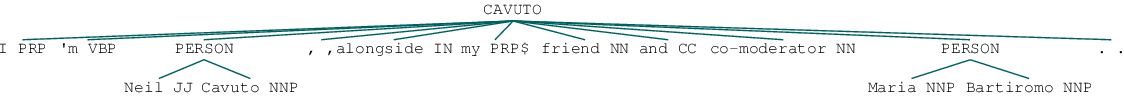

In [12]:
master_df.iloc[2]['Tree'][0]

In [13]:
master_df.iloc[2]['Speaker']

'CAVUTO'

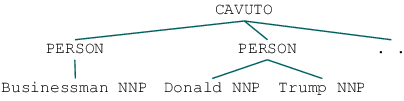

In [14]:
#Uh oh. The good news is the chunker got Trump's title- Businessman. The bad news is it's separated from the rest of his name. I'll have to fix that.
master_df.iloc[8]['Tree'][0]

In [15]:
master_df.iloc[8]['Speaker']

'CAVUTO'

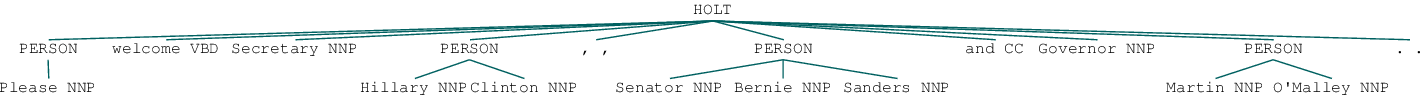

In [16]:
#Again, it got Hillary Clinton and Martin O'Malley, but missed Secretary and Governor, but it DID get Senator Bernie Sanders
master_df.iloc[1603]['Tree'][0]

In [17]:
master_df.iloc[1603]['Speaker']

'HOLT'

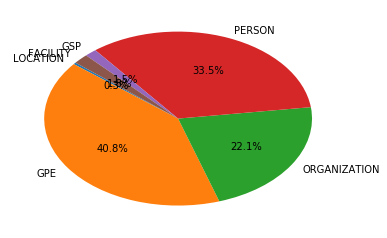

In [18]:
#This section is with help from a datacamp tutorial
#https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/named-entity-recognition?ex=3

ner_categories = defaultdict(int)

# Create the nested for loop
for tree_list in master_df['Tree']:
    for tree in tree_list:
        for chunk in tree:
            if hasattr(chunk, 'label'):
                ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

In [19]:
people = []
for tree_list in master_df['Tree']:
    for tree in tree_list:
        for chunk in tree:
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    people.append(chunk)

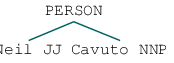

In [20]:
people[1]

In [21]:
people[1].leaves()[0][0]
words = [leaf[0] for leaf in people[1].leaves()]
words

['Neil', 'Cavuto']

In [22]:
people_names = []
name = ''
for tree in people:
    for leaf in tree.leaves():
        name+=' '+str(leaf[0])
    people_names.append(name.strip())
    name = ''


In [23]:
names = set(people_names)
names

{'English', 'Lake Erie', 'John Quincy Adams', 'Garfunkel', 'Bibi Netanyahu', 'Gerry Ohde', 'James Dobson', 'Scott Walker', 'Matter', 'George Bush', 'Rachel', 'Enrique', 'Kim Davis', 'Illinois', 'Lincoln', 'Muslim Brotherhood', 'Senator Gillibrand', 'Gabby', 'Aleppo', 'George Patton', 'Senator Paul', 'Salvador Allende', 'Veterans', 'John Kasich', 'Lady Justice', 'Tamir Rice', 'Lucent', 'Hawley', 'Arab Middle East', 'Sidney', 'Goldman', 'Douglas', 'Karl Rove', 'Moines Register', 'Enough', 'Robert Rubin', 'Dontre Hamilton', 'Howard Dean', 'Verify', 'Mr. Mcgee', 'Jeffrey Sonnenfeld', 'Marijuana', 'Spencer Maass', 'Lockerbie', 'Dan Tuohy', 'Mr. Carson', 'Paul Wellstone', 'Rice', 'Chaznea', 'Social Security', 'Barat', 'Paul Ryan', 'Gore', 'Abe Fortas', 'William F. Buckley', 'Megan', 'Vladimir Putin', 'Rick', 'Nixon', 'Vladimir', 'Steve King', 'Carla Hernandez', 'Mayor Regalado', 'Google', 'Eric', 'Kim Jong-un', 'Kim Jung Un', 'Muhammad Ali', 'Hank', 'Senator Sessions', 'Hillary Rodham', 'Abi

In [24]:
len(names)

1135

In [25]:
'Senator' in names

True

In [26]:
'Governor' in names

False

In [27]:
'Mr.' in names

True

In [28]:
'Mrs.' in names

False

In [29]:
'Miss' in names

False

In [30]:
'Doctor' in names

True

In [31]:
'President' in names

False

**I'm going to go through all of these tags by hand, and link them to who they are referring to. I will create a dictionary in a small additional script that creates a dictionary of NEs. The expression that was used will be the key, and the person it refers to will be the value. I think copying and pasting this set and deleting things that obviously are not people by hand first will speed things up.**

In [32]:
#f = open('/Users/Paige/Documents/Data_Science/names.txt', 'w')
#for name in names:
#    f.write(str(name)+'\n')
#f.close()

**I'm going to read in the text file I made and turn it into the dictionary described above. In this linked.txt file, I removed everyone except for the most relevant people including leaders of countries, all of the candidates, all of the moderators, and people involved in the events discussed during the debate. If the chunker only pulled out a title like 'Madame', I linked it to the value TITLE and can map it more appropriately later on. Other "names" like Lady Liberty and Mr. Average were mapped to NICKNAME unless I knew right away who was being referred to. This will also be fixed later.**

In [33]:
with open('/Users/Paige/Documents/Data_Science/2016-Election-Project/data/Lists/linked.txt') as f:
    name_link = f.readlines()

In [34]:
#I considered 334 of the 1135 found NE's to be relevant to the debates.
len(name_link)

334

In [35]:
name_link[:20]

['Sean Hannity;Sean Hannity\n', 'Jake Tapper;Jake Tapper\n', 'Florida Senator;Marco Rubio\n', 'Hill;Hillary Clinton\n', 'Hey Ted;Ted Cruz\n', 'Bibi Netanyahu;Benjamin Netanyahu\n', 'Madame;TITLE\n', 'Mr. Cruz;Ted Cruz\n', 'Bret;Bret Baier\n', 'John Quincy Adams;John Quincy Adams\n', 'Yasser Arafat;Yasser Arafat\n', 'Rubio;Marco Rubio\n', 'Bobby Jindal;Bobby Jindal\n', 'Andrea;Andrea Mitchell\n', 'Ohio Governor;John Kasich\n', 'Deborah Wasserman Schultz;Deborah Wasserman Schultz\n', 'Ted Cruz;Ted Cruz\n', 'Barak Obama America;Barack Obama\n', 'Jim;Jim Webb\n', 'Shultz;Deborah Wasserman Schultz\n']

In [36]:
links = [x.strip().split(';') for x in name_link]
links[30:50]

[['Barbara Bush', 'Barbara Bush'], ['Lyndon Johnson', 'Lyndon Johnson'], ['Semator', 'TITLE'], ['Martin', "Martin O'Malley"], ['Senator Webb', 'Jim Webb'], ['Lester', 'Lester Holt'], ['David', 'David Muir'], ['Walker', 'Scott Walker'], ['Louisiana Governor Bobby Jindal', 'Bobby Jindal'], ['John Podesta', 'John Podesta'], ['Mr. America', 'NICKNAME'], ['Dana Bash', 'Dana Bash'], ['Brett', 'Bret Baier'], ['Veto Corleone', 'NICKNAME'], ['Fidel Castro', 'Fidel Castro'], ['Ted', 'Ted Cruz'], ['Abraham Lincoln', 'Abraham Lincoln'], ['Biden', 'Joe Biden'], ['Sheriff', 'TITLE'], ['Speaker Paul Ryan', 'Paul Ryan']]

In [37]:
link_dict = {x[0]:x[1] for x in links}

In [38]:
#This is the set of all of the relevant people who were referred to in the debates.
set(link_dict.values())

{'John Quincy Adams', 'Abdullah', 'Scott Walker', 'John Boehner', 'Adolf Hitler', 'George Bush', 'Nelson Mandela', 'Mark Zuckerburg', 'Saddam Hussein', 'Nancy Reagan', 'James Comey', 'Kim Davis', 'Michael Flynn', 'Abigail Adams', 'Dylann Roof', 'Calvin Coolidge', 'Omran Daqneesh', 'Chris Wallace', 'John Kasich', 'Chris Christie', 'Tamir Rice', 'Elizabeth Warren', 'Joseph Stalin', 'Chelsea Clinton', 'Barbara Bush', 'Don Lemon', 'Jim Webb', 'Jeb Bush', 'George W. Bush', 'Eric Garner', 'Paul Ryan', 'Theodore Roosevelt', 'Freddie Gray', 'Martha Raddatz', 'Chris Cuomo', 'Nikki Haley', 'George H. W. Bush', 'Vladimir Putin', 'Lester Holt', 'Bashar al-Assad', 'Rand Paul', 'Major Garrett', "Martin O'Malley", 'Dwight Eisenhower', 'Rudy Giuliani', 'Angela Merkel', "Tip O'Neill", 'Ted Cruz', 'Dana Bash', 'Alexander Hamilton', 'Benjamin Franklin', 'Ivanka Trump', 'Benjamin Netanyahu', 'Bobby Jindal', 'Nancy Pelosi', 'Lincoln Chafee', 'Kimberley Strassel', 'Lyndon Johnson', 'TITLE', 'Winston Churchi

In [39]:
#Here are some of the ways those people were referred to.
list(link_dict.keys())[:40]

['Sean Hannity', 'Jake Tapper', 'Florida Senator', 'Hill', 'Hey Ted', 'Bibi Netanyahu', 'Madame', 'Mr. Cruz', 'Bret', 'John Quincy Adams', 'Yasser Arafat', 'Rubio', 'Bobby Jindal', 'Andrea', 'Ohio Governor', 'Deborah Wasserman Schultz', 'Ted Cruz', 'Barak Obama America', 'Jim', 'Shultz', 'Fiorina', 'Mayor Giuliani', 'Miss Piggy', 'Snowden', 'Malley', 'Martha', 'Dana', 'Hillary Rodham', 'John Mccain', 'Senator Lindsey Graham', 'Barbara Bush', 'Lyndon Johnson', 'Semator', 'Martin', 'Senator Webb', 'Lester', 'David', 'Walker', 'Louisiana Governor Bobby Jindal', 'John Podesta']

In [40]:
link_dict['Ohio Governor']

'John Kasich'

In [41]:
link_dict['Andrea']

'Andrea Mitchell'

In [42]:
link_dict['Senator Webb']

'Jim Webb'

**Now I need to use this dictionary to label all of the named entities in my NER trees with who the NE is referring to instead of PERSON**

In [43]:
def name_linking(trees):
    name = ''
    for tree in trees:
        for chunk in tree:
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    for leaf in chunk.leaves():
                        name+=' '+str(leaf[0])
                        if name.strip() in link_dict.keys():
                            name = name.strip()
                            chunk.set_label(link_dict[name])
                            name = ''
    return tree

In [44]:
master_df['Tree'] = master_df.Tree.map(name_linking)

In [45]:
master_df.head()

,Date,Debate Type,Speaker,Sents,Tree
2,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...,"[(It, PRP), (is, VBZ), (9:00, CD), (p.m., NN),..."
3,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...,"[(Welcome, VB), (to, TO), (the, DT), (sixth, J..."
4,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo...","[(I, PRP), ('m, VBP), [(Neil, JJ), (Cavuto, NN..."
5,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...,"[(Tonight, NN), (we, PRP), (are, VBP), (workin..."
6,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h...","[(And, CC), (according, VBG), (to, TO), [(Face..."


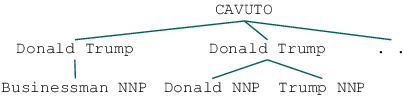

In [46]:
master_df.iloc[8][-1]

**Below is some basic analysis that I can do at this point! Here are the counts for each time a particular person was referrenced from high to low.**

In [47]:
ner_categories = defaultdict(int)

# Create the nested for loop
for tree in master_df['Tree']:
    for chunk in tree:
        if hasattr(chunk, 'label') and chunk.label() not in ['GPE', 'ORGANIZATION', 'PERSON', 'LOCATION', 'GSP', 'FACILITY' ]:
            ner_categories[chunk.label()] += 1

for category in sorted(ner_categories, key=ner_categories.get, reverse=True):
    print(category, ner_categories[category])

Hillary Clinton 1093
Donald Trump 679
Barack Obama 471
TITLE 308
Bernie Sanders 211
Jeb Bush 201
Ben Carson 179
Marco Rubio 172
John Kasich 163
Ronald Reagan 124
Rand Paul 103
Ted Cruz 102
Vladimir Putin 99
Bashar al-Assad 97
Anderson Cooper 64
Chris Christie 51
David Muir 48
Dana Bash 46
John Kerry 42
Wolf Blitzer 41
Martha Raddatz 38
Carly Fiorina 35
Lester Holt 32
Muammar Gaddafi 32
Megyn Kelly 29
Mitt Romney 25
Saddam Hussein 24
Bret Baier 20
Martin O'Malley 18
Bill Clinton 18
Maria Celeste Arraras 17
Andrea Mitchell 17
John Kennedy 15
Edward Snowden 14
Jim Webb 14
Osama bin Laden 14
Antonin Scalia 14
Joe Biden 12
Jeff Sessions 12
John McCain 11
Nancy Pelosi 11
Don Lemon 11
Kim Jong Un 10
George Bush 9
Chuck Schumer 9
Scott Walker 9
Benjamin Netanyahu 9
James Carter 8
Lindsey Graham 8
Rick Santorum 8
Elizabeth Warren 8
Hugh Hewitt 8
Jake Tapper 8
Nikki Haley 7
Theodore Roosevelt 7
Mike Huckabee 7
Lincoln Chafee 7
Harry Truman 6
Sean Hannity 6
Eric Trump 5
Chuck Todd 5
John Adams 5


**Here is a distribution across the candidates that remained in the race until the last primary debate.**

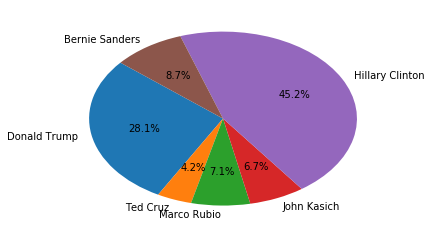

In [48]:
#This section is with help from a datacamp tutorial
#https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/named-entity-recognition?ex=3

ner_categories = defaultdict(int)

# Create the nested for loop
for tree in master_df['Tree']:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            if chunk.label() in ['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Ted Cruz', 'Marco Rubio', 'John Kasich']:
                ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

**Next Steps: I still need to fix up some of the tagging to include titles and maybe go through the ORGANIZATION and LOCATION tags to see if some people were mistakenly tagged as such. Then I need to begin my analysis and see if there is a difference in the way females and males are referred to.**